In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [5]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient("http://127.0.0.1:5000")  # uses MLFLOW_TRACKING_URI if set
# find deleted experiments (optional)
# deleted = client.search_experiments(ViewType.DELETED_ONLY)
# deleted


In [6]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    # numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df = df_train
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')
train_len = len(df_train)
val_len = len(df_val)

In [9]:
print(train_len/(train_len+val_len), val_len/(train_len+val_len))
print(f"train_len, val_len : {train_len}, {val_len}")

0.5441253340597368 0.4558746659402631
train_len, val_len : 73908, 61921


In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
# Turns a dictionary into a vector

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RMSE = 7.479545309801227 minutes


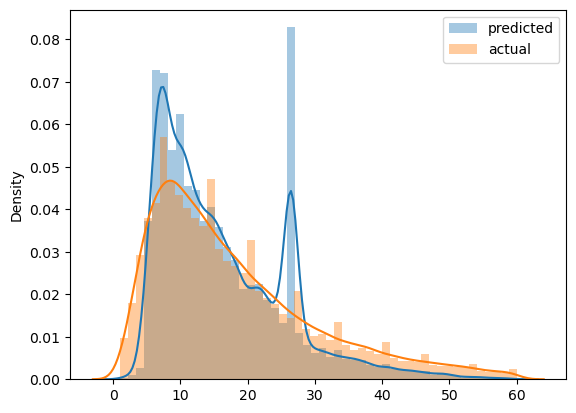

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

RMSE = mean_squared_error(y_val, y_pred, squared=False)
# RMSE = root_mean_squared_error(y_val, y_pred)
# squared = False gives RMSE
# RMSE is initially 9.8 minutes
# If we get rid of the categorical variables, RMSE goes up to 11.6 minutes

sns.distplot(y_pred, label='predicted')
sns.distplot(y_val, label='actual')
plt.legend()
print(f"RMSE = {RMSE} minutes")

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

RMSE = 12.143233939663894 minutes


/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


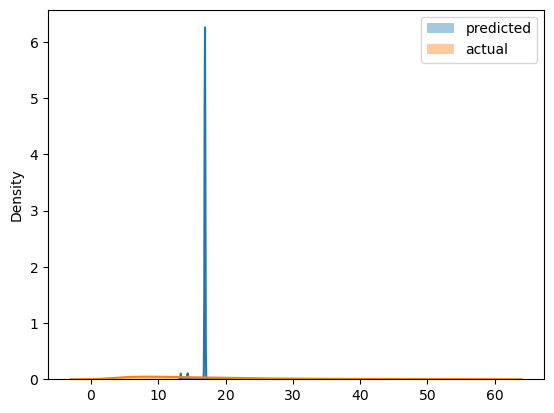

In [14]:
with mlflow.start_run():
    mlflow.set_tag("developer", "chad")
    mlflow.log_param('train-data-path', './data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', './data/green_tripdata_2021-02.parquet')
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha=0.1)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    RMSE = mean_squared_error(y_val, y_pred, squared=False)
    # squared = False gives RMSE
    # RMSE is initially 9.8 minutes
    # If we get rid of the categorical variables, RMSE goes up to 11.6 minutes
    mlflow.log_artifact('models/lin_reg.bin', 'models_pickle')

    sns.distplot(y_pred, label='predicted')
    sns.distplot(y_val, label='actual')
    plt.legend()
    print(f"RMSE = {RMSE} minutes")


/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RMSE = 11.342603943257998 minutes


/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


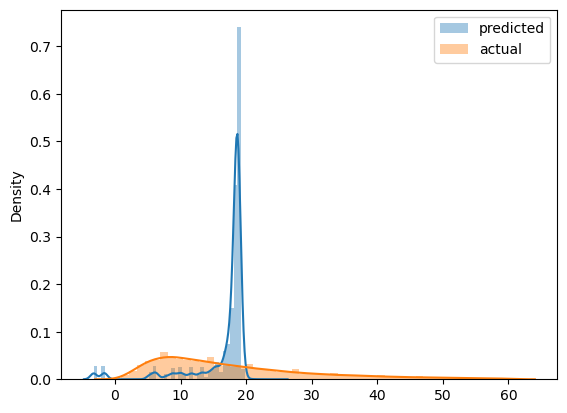

In [15]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

RMSE = mean_squared_error(y_val, y_pred, squared=False)
# squared = False gives RMSE
# RMSE is initially 9.8 minutes
# If we get rid of the categorical variables, RMSE goes up to 11.6 minutes

sns.distplot(y_pred, label='predicted')
sns.distplot(y_val, label='actual')
plt.legend()
print(f"RMSE = {RMSE} minutes")

Run an XGBoost (progressive decision tree) model on the data and traverse a wide parameter search space with early stopping

In [16]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("developer", "chad")
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        RMSE = mean_squared_error(y_val, y_pred, squared=False)

        mlflow.log_metric("RMSE", RMSE)

    return {'loss': RMSE, 'status': STATUS_OK}

In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[23:41:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.38195                          
[1]	validation-rmse:14.48720                          
[2]	validation-rmse:12.31403                          
[3]	validation-rmse:10.71037                          
[4]	validation-rmse:9.54322                           
[5]	validation-rmse:8.70861                           
[6]	validation-rmse:8.11662                           
[7]	validation-rmse:7.70808                           
[8]	validation-rmse:7.42105                           
[9]	validation-rmse:7.21922                           
[10]	validation-rmse:7.07859                          
[11]	validation-rmse:6.97804                          
[12]	validation-rmse:6.90322                          
[13]	validation-rmse:6.84917                          
[14]	validation-rmse:6.80588                  

job exception: name 'root_mean_squared_error' is not defined



  0%|          | 0/50 [00:09<?, ?trial/s, best loss=?]


NameError: name 'root_mean_squared_error' is not defined

Save the best XGBoost run and log the model and parameters

In [ ]:
# They disabled the autologging in the course video
# I think it should be enabled in this version of mlflow to get model prediction snippet suggestions and signature inference.
# mlflow.xgboost.autolog(disable=True)

In [36]:
with mlflow.start_run():
    mlflow.xgboost.autolog()
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09740150252549278,
        'max_depth': 44,
        'min_child_weight': 1.5616751377711606,
        'objective': 'reg:linear',
        'reg_alpha': 1.8740591729080365,
        'reg_lambda': 0.00305751666263708,
        'seed': 42
    }

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    mlflow.log_metric("RMSE", mean_squared_error(y_val, y_pred, squared=False)
)
    # sns.distplot(y_val, label='actual')
    # sns.distplot(y_pred, label='predicted')

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact('models/preprocessor.b', 'preprocessor')

    # mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


[18:22:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.45179
[1]	validation-rmse:17.89780
[2]	validation-rmse:16.51156
[3]	validation-rmse:15.27575
[4]	validation-rmse:14.18118
[5]	validation-rmse:13.20900
[6]	validation-rmse:12.35093
[7]	validation-rmse:11.59423
[8]	validation-rmse:10.92715
[9]	validation-rmse:10.34399
[10]	validation-rmse:9.83407
[11]	validation-rmse:9.38829
[12]	validation-rmse:8.99991
[13]	validation-rmse:8.66348
[14]	validation-rmse:8.37027
[15]	validation-rmse:8.11819
[16]	validation-rmse:7.89992
[17]	validation-rmse:7.70869
[18]	validation-rmse:7.54436
[19]	validation-rmse:7.40396
[20]	validation-rmse:7.28224
[21]	validation-rmse:7.17818
[22]	validation-rmse:7.08711
[23]	validation-rmse:7.00839
[24]	validation-rmse:6.94091
[25]	validation-rmse:6.88171
[26]	validation-rmse:6.83023
[27]	validation-rmse:6.78411
[28]

Got this snippet from the MLFlow UI. Load the model from the database.

In [22]:
import mlflow
logged_model = 'runs:/4cd55e3ea2a041298c8843a94043d575/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


[23:45:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [23]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 4cd55e3ea2a041298c8843a94043d575

In [24]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[23:45:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
y_pred = xgboost_model.predict(valid)

Confirm that the loaded model is the same as the one before.

/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

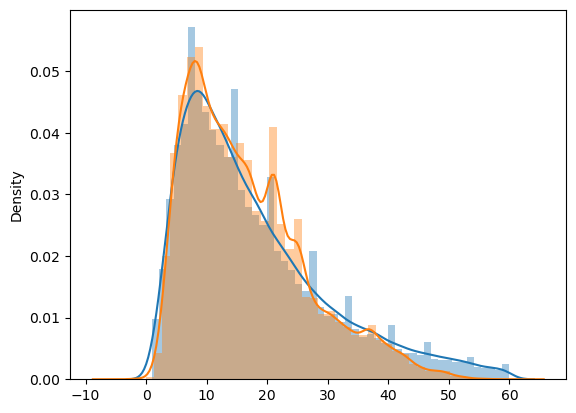

In [26]:
sns.distplot(y_val, label='actual')
sns.distplot(y_pred, label='predicted')

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

In [28]:
gbr = GradientBoostingRegressor()
print(gbr.get_params().keys())
print()
print(gbr.get_params())

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [29]:
mlflow.sklearn.autolog()

In [32]:
# for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
for model_class in (ExtraTreesRegressor, LinearSVR):
    print(f"Fitting model: {str(model_class)}")
    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(f"rmse = {rmse}")
        mlflow.log_metric("rmse", rmse)

Fitting model: <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
rmse = 6.918372193230343
Fitting model: <class 'sklearn.svm._classes.LinearSVR'>


/Users/chadcasper/.pyenv/versions/miniforge3-4.10.3-10/envs/exp-tracking/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


rmse = 832.0742784678949
